## Ensemble Model - Indice Futuro

 

#### Etapas


- Passo 1 - Carregar as bibliotecas

- Passo 2 - Carregar a base de dados

- Passo 3 - Ajustes e Construçao dos alvos

- Passo 4 - Construçao das Variaveis

- Passo 5 - Preparaçao da base para treinamento e teste

- Passo 6 - Treinamento do Ensemble

- Passo 7 - Predict

- Passo 8 - Salvar e carregar o modelo
________________________________________________________


### Passo 1 - Carregar as bibliotecas

In [1]:
# Carregando as bibliotecas

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as metrics
import ta
get_ipython().run_line_magic("matplotlib", "inline")
import warnings
warnings.filterwarnings("ignore")

______________________________________________________

### Passo 2 - Carregar a base de dados

In [2]:
# Carregando a base de dados e fazendo os checks iniciais

# Muda o diretorio de trabalho
import os
os.chdir("C:\\Users\\User\\Documents\\Bases de dados")

df1 = pd.read_csv("EURUSD1.csv", sep = ",")

______________________________________________________

### Passo 3 - Ajustes e Construçao dos alvos

In [3]:
# Ajustando a data e o nome das colunas

df1 = df1.rename(columns={"1971.01.04" :"data", "00:00" : "hora", "0.53690": "open", "0.53690.1" : "high", "0.53690.2" : "low", "0.53690.3" : "close", "1" : "volume"})

df1["data"] = pd.to_datetime(df1["data"]).dt.normalize()

df1 = df1.set_index("data")

In [4]:
# Construcao dos alvo

periodos = 2

# Alvo 1 - Retorno
df1["Retorno"] = df1["close"].pct_change(periodos)
df1["Alvo1"] = df1["Retorno"].shift(-periodos)

# Variaçao em Pontos do alvo
df1["Pontos"] = (df1["close"] - df1["close"].shift(1))*10000
df1["Pontos"] = df1["Pontos"].shift(-periodos)

# Criacao do alvo categorico
df1["Alvo1_cat"] = np.where(df1["Alvo1"] > 0 , 1, -1)

______________________________________________________

### Passo 4 - Construçao das Variaveis

In [5]:
# Construçao das Variaveis

# Desvio Padrao de 5 dias
df1["std5"] = df1["close"].rolling(5).std()

# Desvio Padrao de 10 dias
df1["std10"] = df1["close"].rolling(10).std()

# Desvio Padrao de 15 dias
df1["std15"] = df1["close"].rolling(15).std()

# Proporçao do corpo do candle em relacao ao range do dia
df1["prop"] = (df1["close"]-df1["open"])/(df1["high"]-df1["low"])

# Direçao do dia atual
df1["dir_D"] = np.where(df1["close"] > df1["open"] , "1", "0")

# Direçao D-1
df1["dir_D-1"] = df1["dir_D"].shift(1)

# Direçao D-2
df1["dir_D-2"] = df1["dir_D"].shift(2)

# Direçao D-3
df1["dir_D-3"] = df1["dir_D"].shift(3)

# Media Movel de 15 dias std5
df1["mm_std5"] = df1["std5"].rolling(15).mean()

# Media Movel de 15 dias std5
df1["mm_std10"] = df1["std10"].rolling(15).mean()

# Media Movel de 15 dias std5
df1["mm_std15"] = df1["std15"].rolling(15).mean()

# RSL std5
df1["RSL_std5"] = (df1["std5"]/df1["std5"].rolling(15).mean())-1

# RSL std10
df1["RSL_std10"] = (df1["std10"]/df1["std10"].rolling(15).mean())-1

# RSL std15
df1["RSL_std15"] = (df1["std15"]/df1["std15"].rolling(15).mean())-1

# Aplicando a fisica

p = 2

# Velocidade de p dias
df1["v"] = (df1["Retorno"] - df1["Retorno"].shift(p))/p

# Aceleraçao de p dias
df1["a"] = (df1["v"] - df1["v"].shift(p))/p

# Força
# Calculando a massa
df1["m"] = df1["Retorno"].rolling(p).sum()
df1["f"] = df1["m"]*df1["a"]

# Energia cinética
df1["T"] = 0.5*df1["m"]*df1["v"]*df1["v"]

# Trabalho 
# cateto_oposto
cat_op = df1["Retorno"].rolling(p).sum()-df1["Retorno"].rolling(1).sum()
cat_ad = p
df1["cat"] = cat_op/cat_ad
df1 = df1.dropna(axis = 0)
df1["w"] = df1["f"]*np.cos(np.arctan(df1["cat"]))

# Energia potencial
df1["k"] = cat_op*df1["m"]

# Torque
df1["tau"] = df1["f"]*np.sin(np.arctan(df1["cat"]))

# Momentum
df1["M"] = df1["m"]*df1["v"]

# Gravidade
df1["g"] = df1["m"]*df1["Retorno"].rolling(p).sum()/(df1["m"]/df1["Retorno"].rolling(p).sum())*(df1["m"]/df1["Retorno"].rolling(p).sum())

# Para o zig zag dos retornos
df1["Retorno1"] = df1["Retorno"].shift(1)
df1["Retorno2"] = df1["Retorno"].shift(2)

df1["Zigzag_alta"] = np.where(((df1["Retorno"] > 0) & (df1["Retorno1"] < 0) & (df1["Retorno2"] > 0)), 1, 0)
df1["Zigzag_baixa"] = np.where(((df1["Retorno"] < 0) & (df1["Retorno1"] > 0) & (df1["Retorno2"] < 0)), -1, 0)
df1["Zigzag"] = df1["Zigzag_alta"] + df1["Zigzag_baixa"]

# Resistencia - R=V/I onde V é a amplitude maxima dos ultimos retornos
# Novo periodo
p = 2

df1["V_Max"] = df1["Retorno"].rolling(p).max()
df1["V_Min"] = df1["Retorno"].rolling(p).min()
df1["I"] = df1["Retorno"].rolling(p).sum()


In [6]:
# Variaveis de Indicadores técnicos - Biblioteca TA

# Inicializa o indicador
indicator_atr14 = ta.volatility.AverageTrueRange(high = df1["high"], low = df1["low"]
                                                  , close = df1["close"], window = 14)

indicator_bb = ta.volatility.bollinger_wband(close = df1["close"], window = 20, window_dev = 2)
indicator_rsi14 = ta.momentum.RSIIndicator(close = df1["close"], window = 14)
indicator_rsi2 = ta.momentum.RSIIndicator(close = df1["close"], window = 2)
indicator_stoc = ta.momentum.StochasticOscillator(high= df1["high"], low = df1["low"]
                                                  , close = df1["close"], window = 14, smooth_window = 3)
indicator_adx = ta.trend.ADXIndicator(high = df1["high"], low= df1["low"], close = df1["close"], window= 14)
indicator_ichimoko = ta.trend.IchimokuIndicator(high= df1["high"], low = df1["low"], window1 = 9, window2 = 26, window3= 52)
indicator_macd  =ta.trend.MACD(close= df1["close"], window_slow = 26, window_fast = 12, window_sign = 9)
indicator_ema = ta.trend.EMAIndicator(close = df1["close"], window= 9)
# Variavel abertura das bandas
df1["abertura_bb"] = indicator_bb
df1["RSI14"] = indicator_rsi14.rsi()
df1["RSI2"] = indicator_rsi2.rsi()
df1["STOC"] = indicator_stoc.stoch()
df1["ATR14"] = indicator_atr14.average_true_range()
df1["ADX"] = indicator_adx.adx()
df1["EMA"] = indicator_ema.ema_indicator()
df1["ICK"] = indicator_ichimoko.ichimoku_a()
df1["MACD"] = indicator_macd.macd()

In [7]:
# Filtrando os valores missing

df1_filtrado = df1.dropna(axis = 0) 

df1_filtrado = df1_filtrado.drop(["mm_std5", "mm_std10", "mm_std15", "Retorno1"
                                  , "Retorno2", "Zigzag_alta", "Zigzag_baixa"
                                 ], axis = 1)

df2 = df1_filtrado.copy()

In [8]:
corte = 5

In [9]:


df1_filtrado["RSL_std5"] = pd.qcut(df1_filtrado["RSL_std5"], corte, labels = False)
df1_filtrado["RSL_std10"] = pd.qcut(df1_filtrado["RSL_std10"], corte, labels = False)
df1_filtrado["RSL_std15"] = pd.qcut(df1_filtrado["RSL_std15"], corte, labels = False)
df1_filtrado["v"] = pd.qcut(df1_filtrado["v"], corte, labels = False)
df1_filtrado["a"] = pd.qcut(df1_filtrado["a"], corte, labels = False)
df1_filtrado["m"] = pd.qcut(df1_filtrado["m"], corte, labels = False)
df1_filtrado["f"] = pd.qcut(df1_filtrado["f"], corte, labels = False)
df1_filtrado["T"] = pd.qcut(df1_filtrado["T"], corte, labels = False)
df1_filtrado["w"] = pd.qcut(df1_filtrado["w"], corte, labels = False)
df1_filtrado["k"] = pd.qcut(df1_filtrado["k"], corte, labels = False)
df1_filtrado["tau"] = pd.qcut(df1_filtrado["tau"], corte, labels = False)
df1_filtrado["M"] = pd.qcut(df1_filtrado["M"], corte, labels = False)
df1_filtrado["g"] = pd.qcut(df1_filtrado["g"], corte, labels = False)


In [10]:
pd.qcut(df2["g"], corte, labels = None).unique()

[(-0.001134, 9.01e-06], (9.01e-06, 4.31e-05], (4.31e-05, 0.000122], (0.000122, 0.000333], (0.000333, 0.0119]]
Categories (5, interval[float64]): [(-0.001134, 9.01e-06] < (9.01e-06, 4.31e-05] < (4.31e-05, 0.000122] < (0.000122, 0.000333] < (0.000333, 0.0119]]

In [11]:
# Criando variàveis com os resultados do pd.qcut
# Criando um sistema que vai interpretar o valor que vai ser dado pela variavel euqe se pode atingir o mesmo valor do pd.qcut

#Exemplo
RSL_std5_cut = np.where(df2["RSL_std5"] <= -0.396, 0
                        , np.where(((df2["RSL_std5"] > -0.396) & (df2["RSL_std5"] <= -0.185)), 1
                                  , np.where(((df2["RSL_std5"] > -0.185) & (df2["RSL_std5"] <= 0.0473)), 2
                                            , np.where(((df2["RSL_std5"] > 0.0473) & (df2["RSL_std5"] <= 0.386)), 3
                                                      , 4)
                                            )
                                  )
                       )

RSL_std10_cut = np.where(df2["RSL_std10"] <= -0.329, 0
                        , np.where(((df2["RSL_std10"] > -0.329) & (df2["RSL_std10"] <= -0.134)), 1
                                  , np.where(((df2["RSL_std10"] > -0.134) & (df2["RSL_std10"] <= 0.0663)), 2
                                            , np.where(((df2["RSL_std10"] > 0.0663) & (df2["RSL_std10"] <= 0.342)), 3
                                                      , 4)
                                            )
                                  )
                       )

RSL_std15_cut = np.where(df2["RSL_std15"] <= -0.29, 0
                        , np.where(((df2["RSL_std15"] > -0.29) & (df2["RSL_std15"] <= -0.105)), 1
                                  , np.where(((df2["RSL_std15"] > -0.105) & (df2["RSL_std15"] <= 0.0698)), 2
                                            , np.where(((df2["RSL_std15"] > 0.0698) & (df2["RSL_std15"] <= 0.314)), 3
                                                      , 4)
                                            )
                                  )
                       )
                    
v_cut = np.where(df2["v"] <= -0.00466, 0
                        , np.where(((df2["v"] > -0.00466) & (df2["v"] <= -0.00132)), 1
                                  , np.where(((df2["v"] > -0.132) & (df2["v"] <= 0.00141)), 2
                                            , np.where(((df2["v"] > 0.00141) & (df2["v"] <= 0.00456)), 3
                                                      , 4)
                                            )
                                  )
                       )

a_cut = np.where(df2["a"] <= -0.00399, 0
                        , np.where(((df2["a"] > -0.00399) & (df2["a"] <= -0.00109)), 1
                                  , np.where(((df2["a"] > -0.00109) & (df2["a"] <= 0.00116)), 2
                                            , np.where(((df2["a"] > 0.00116) & (df2["a"] <= 0.00402)), 3
                                                      , 4)
                                            )
                                  )
                       )
    
m_cut = np.where(df2["m"] <= -0.0108, 0
                        , np.where(((df2["m"] > -0.0108) & (df2["m"] <= -0.00293)), 1
                                  , np.where(((df2["m"] > -0.00293) & (df2["m"] <= 0.0032)), 2
                                            , np.where(((df2["m"] > 0.0032) & (df2["m"] <= 0.0115)), 3
                                                      , 4)
                                            )
                                  )
                       )

f_cut = np.where(df2["f"] <= -2.62e-05, 0
                        , np.where(((df2["f"] > -2.62e-05) & (df2["f"] <=  -2.21e-06)), 1
                                  , np.where(((df2["f"] >  -2.21e-06) & (df2["f"] <=7.89e-06)), 2
                                            , np.where(((df2["f"] > 7.89e-06) & (df2["f"] <= 3.97e-05)), 3
                                                      , 4)
                                            )
                                  )
                       ) 

w_cut = np.where(df2["w"] <= -2.62e-05, 0
                        , np.where(((df2["w"] > -2.62e-05) & (df2["w"] <= -2.21e-06)), 1
                                  , np.where(((df2["w"] >-2.21e-06) & (df2["w"] <= 7.89e-06)), 2
                                            , np.where(((df2["w"] >7.89e-06) & (df2["w"] <=  3.97e-05)), 3
                                                      , 4)
                                            )
                                  )
                       )       

k_cut = np.where(df2["k"] <= 8.49e-07, 0
                        , np.where(((df2["k"] > 8.49e-07) & (df2["k"] <= 1.67e-05)), 1
                                  , np.where(((df2["k"] > 1.67e-05) & (df2["k"] <=5.9e-05)), 2
                                            , np.where(((df2["k"] >5.9e-05) & (df2["k"] <= 0.000169)), 3
                                                      , 4)
                                            )
                                  )
                       ) 

tau_cut = np.where(df2["tau"] <= -8.41e-08, 0
                        , np.where(((df2["tau"] > -8.41e-08) & (df2["tau"] <= -4.17e-09)), 1
                                  , np.where(((df2["tau"] > -4.17e-09) & (df2["tau"] <=5.37e-09)), 2
                                            , np.where(((df2["tau"] > 5.37e-09) & (df2["tau"] <= 8.49e-08)), 3
                                                      , 4)
                                            )
                                  )
                       )        

M_cut = np.where(df2["M"] <= -1.27e-05, 0
                        , np.where(((df2["M"] > -1.27e-05) & (df2["M"] <= 1.35e-06)), 1
                                  , np.where(((df2["M"] > 1.35e-06) & (df2["M"] <=1.94e-05)), 2
                                            , np.where(((df2["M"] > 1.94e-05) & (df2["M"] <= 7.05e-05)), 3
                                                      , 4)
                                            )
                                  )
                       )   

g_cut = np.where(df2["g"] <= 8.92e-06, 0
                        , np.where(((df2["g"] > 8.92e-06) & (df2["g"] <= 4.29e-05)), 1
                                  , np.where(((df2["g"] > 4.29e-05) & (df2["g"] <= 0.000122)), 2
                                            , np.where(((df2["g"] > 0.000122) & (df2["g"] <= 0.000333)), 3
                                                      , 4)
                                            )
                                  )
                       ) 


In [12]:
f_cut

array([2, 1, 1, ..., 4, 3, 1])

In [13]:
df1_filtrado["f"]

data
1972-07-17    2
1972-07-20    1
1972-07-21    1
1972-07-24    2
1972-07-25    2
             ..
2022-02-22    1
2022-02-23    2
2022-02-24    4
2022-02-25    3
2022-02-28    1
Name: f, Length: 11860, dtype: int64

In [14]:
df1_filtrado = df1_filtrado.drop(["hora", "volume"], axis = 1)

In [15]:
df1_filtrado.tail()

,open,high,low,close,Retorno,Alvo1,Pontos,Alvo1_cat,std5,std10,...,I,abertura_bb,RSI14,RSI2,STOC,ATR14,ADX,EMA,ICK,MACD
data,,,,,,,,,,,,,,,,,,,,,
2022-02-22,1.13146,1.13668,1.12879,1.13240,0.000212,-0.011780,-113.3,-1,0.002540,0.004295,...,-0.003635,3.144091,47.728276,41.365958,25.043860,0.007527,15.116702,1.134274,1.134775,0.000169
2022-02-23,1.13253,1.13589,1.13011,1.13039,-0.001052,-0.003494,73.8,-1,0.002081,0.003804,...,-0.000840,3.062319,45.565704,16.243575,11.162791,0.007402,14.233582,1.133497,1.133145,-0.000171
2022-02-24,1.13045,1.13086,1.11063,1.11906,-0.011780,0.002440,-46.5,1,0.005676,0.005123,...,-0.012832,2.898670,35.736374,2.070114,21.693258,0.008318,15.720543,1.130610,1.127582,-0.001340
2022-02-25,1.11898,1.12739,1.11659,1.12644,-0.003494,-0.012890,-98.7,-1,0.005483,0.005309,...,-0.015275,2.537151,44.182665,54.167969,40.684508,0.008495,17.101292,1.129776,1.127582,-0.001652
2022-02-28,1.11251,1.12464,1.11245,1.12179,0.002440,-0.008700,1.1,-1,0.005619,0.006087,...,-0.001055,2.584959,40.564960,32.428227,28.718477,0.008888,18.769134,1.128179,1.127582,-0.002249


______________________________________________________

### Passo 5 - Preparaçao da base para treinamento e teste

In [16]:
# Separando os dados entre treinamento e teste

# Vamos treinar o modelo de 1972 a 1997
start_train = "1972-06-08"
end_train = "1997-12-31"

# Vamos testar o modelo de 2010 a 2021
start_test = "1998-01-01"
end_test = "2022-02-28"

df1_train = df1_filtrado.loc[start_train : end_train]

df1_test = df1_filtrado.loc[start_test : end_test]

In [17]:
df1_filtrado.columns[8:]

Index(['std5', 'std10', 'std15', 'prop', 'dir_D', 'dir_D-1', 'dir_D-2',
       'dir_D-3', 'RSL_std5', 'RSL_std10', 'RSL_std15', 'v', 'a', 'm', 'f',
       'T', 'cat', 'w', 'k', 'tau', 'M', 'g', 'Zigzag', 'V_Max', 'V_Min', 'I',
       'abertura_bb', 'RSI14', 'RSI2', 'STOC', 'ATR14', 'ADX', 'EMA', 'ICK',
       'MACD'],
      dtype='object')

In [18]:
# Separando os dados com as variaveis em x e o alvo em y
 
x_train = df1_train.iloc[:, 8:df1_filtrado.shape[1]]
y_train = df1_train["Alvo1_cat"]

x_test = df1_test.iloc[:, 8:df1_filtrado.shape[1]]
y_test = df1_test["Alvo1_cat"]

______________________________________________________

### Passo 6 - Treinamento do Ensemble

In [19]:
modelos = [
                ("Emod1", LogisticRegression(random_state = 42))
                , ("Emod2", DecisionTreeClassifier(criterion = "gini", max_depth = 3, random_state = 42))
                , ("Emod3", DecisionTreeClassifier(criterion = "gini", max_depth = 8, random_state = 42))
                , ("Emod4", DecisionTreeClassifier(criterion = "gini", max_depth = 10, random_state = 42))
            ]

e_multi = StackingClassifier(modelos, final_estimator = DecisionTreeClassifier(
                                       criterion = "gini"
                                     , max_depth = 3
                                     , min_samples_leaf = 15
                                     , min_samples_split = 20
                                     , max_leaf_nodes = 15
                                     , random_state = 42)
                                        , passthrough = True)
e_multi.fit(x_train, y_train)

y_pred_train_e_multi = e_multi.predict(x_train)
y_pred_test_e_multi = e_multi.predict(x_test)

______________________________________________________

In [20]:
df1_filtrado.columns[8:]

Index(['std5', 'std10', 'std15', 'prop', 'dir_D', 'dir_D-1', 'dir_D-2',
       'dir_D-3', 'RSL_std5', 'RSL_std10', 'RSL_std15', 'v', 'a', 'm', 'f',
       'T', 'cat', 'w', 'k', 'tau', 'M', 'g', 'Zigzag', 'V_Max', 'V_Min', 'I',
       'abertura_bb', 'RSI14', 'RSI2', 'STOC', 'ATR14', 'ADX', 'EMA', 'ICK',
       'MACD'],
      dtype='object')

### Passo 7 - Predict

In [21]:
# Calculando a performance - para toda a base

y_pred_all = e_multi.predict(df1_filtrado.iloc[:, 8:df1_filtrado.shape[1]])
df1_filtrado.loc[: , "Previsto"] = y_pred_all
df1_filtrado.loc[: , "Retorno_Modelo"] = df1_filtrado.loc[: , "Previsto"]*df1_filtrado["Alvo1"]

In [22]:
# Acuràcias

print("Mod1 Treino:", round(metrics.accuracy_score(y_train, y_pred_train_e_multi),2)*100)
print("Mod1 Teste:", round(metrics.accuracy_score(y_test, y_pred_test_e_multi),2)*100)

print("Mod2 Treino:", round(metrics.accuracy_score(y_train, y_pred_train_e_multi),2)*100)
print("Mod2 Teste:", round(metrics.accuracy_score(y_test, y_pred_test_e_multi),2)*100)

print("Mod3 Treino:", round(metrics.accuracy_score(y_train, y_pred_train_e_multi),2)*100)
print("Mod3 Teste:", round(metrics.accuracy_score(y_test, y_pred_test_e_multi),3)*100)

print("Mod4 Treino:", round(metrics.accuracy_score(y_train, y_pred_train_e_multi),3)*100)
print("Mod4 Teste:", round(metrics.accuracy_score(y_test, y_pred_test_e_multi),3)*100)

Mod1 Treino: 56.00000000000001
Mod1 Teste: 50.0
Mod2 Treino: 56.00000000000001
Mod2 Teste: 50.0
Mod3 Treino: 56.00000000000001
Mod3 Teste: 50.1
Mod4 Treino: 56.10000000000001
Mod4 Teste: 50.1


In [23]:
# Como availar os resultados?

print(confusion_matrix(y_test, y_pred_test_e_multi))
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report(y_test, y_pred_test_e_multi))

[[ 852 2278]
 [ 851 2286]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

          -1       0.50      0.27      0.35      3130
           1       0.50      0.73      0.59      3137

    accuracy                           0.50      6267
   macro avg       0.50      0.50      0.47      6267
weighted avg       0.50      0.50      0.47      6267



In [24]:
# Para fazer um conditional plot

df1_filtrado.index.name = "data"
df1_filtrado.reset_index(inplace = True)

df1_filtrado["data"] = pd.to_datetime(df1_filtrado["data"])

df1_filtrado["train_test"] = np.where(df1_filtrado["data"] > end_train, 1, -1)

base_agregada = df1_filtrado.resample("M", on = "data").sum()

base_agregada.loc[: , "Retorno_Modelo_Acumulado"] = base_agregada["Retorno_Modelo"].cumsum()*100

""


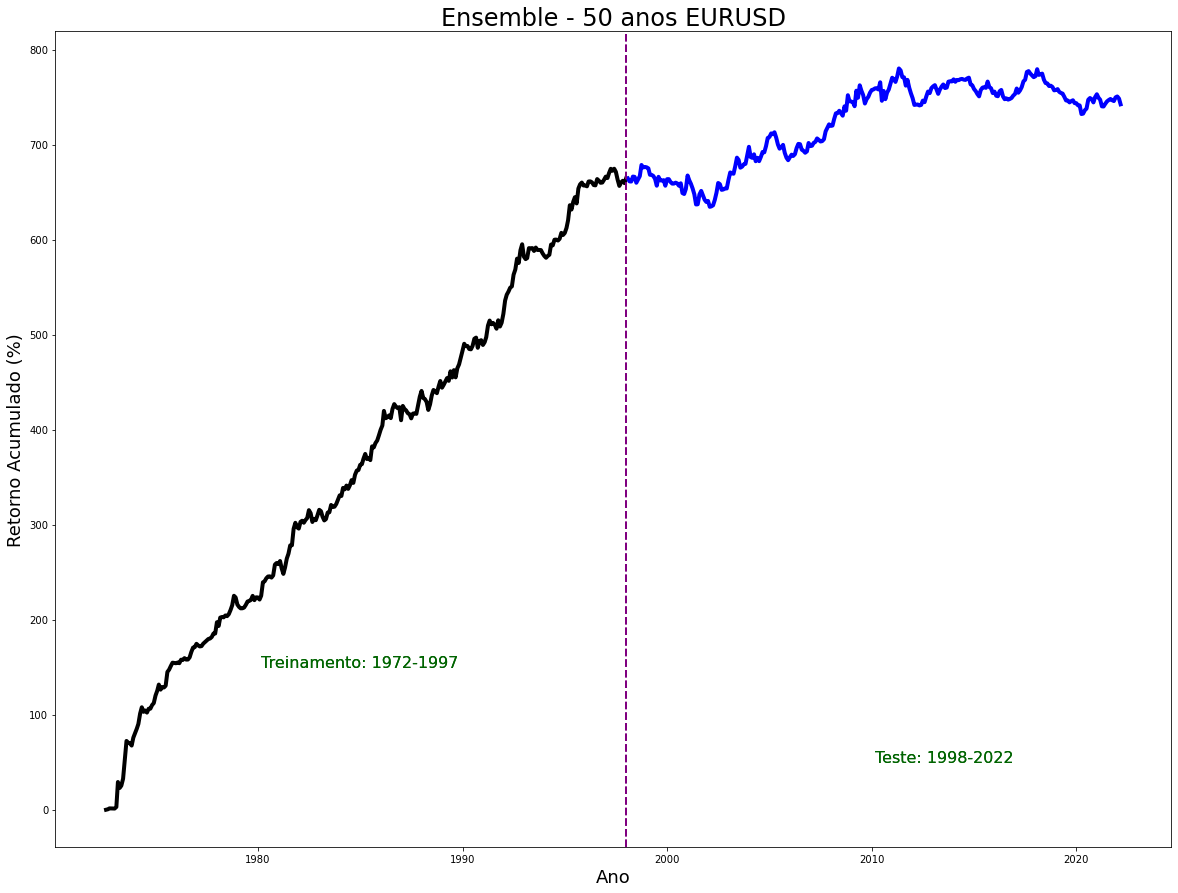

In [25]:
import datetime

# Plota o grafico
fig, ax = plt.subplots(figsize = (20,15))

def grafico(group):
    color = "black" if (group["train_test"] < 0).all() else "blue"
    lw = 4.0
    ax.plot(group.index, group.Retorno_Modelo_Acumulado, c = color, linewidth = lw)
    plt.xlabel("Ano"
           , fontsize = 18);
    plt.ylabel("Retorno Acumulado (%)"
           , fontsize = 18);
    plt.title("Ensemble - 50 anos EURUSD", fontsize = 24)
    plt.axvline( x = datetime.datetime.strptime(end_train,'%Y-%m-%d'), color='purple', linestyle = "--", lw = 2)
    setup = dict(size = 16, color = "darkgreen")
    setup2 = dict(size = 14, color = "black")
    plt.text(datetime.datetime.strptime("1980-03-01",'%Y-%m-%d'), 150, "Treinamento: 1972-1997", **setup)
    plt.text(datetime.datetime.strptime("2010-03-01",'%Y-%m-%d'), 50, "Teste: 1998-2022", **setup)
   # plt.text(datetime.datetime.strptime("2010-03-01",'%Y-%m-%d'), 360, "www.outspokenmarket.com", **setup2)

base_agregada.groupby((base_agregada["train_test"].shift() * base_agregada["train_test"] < 0).cumsum()).apply(grafico)

In [26]:
# Calculando a performance - para a base de teste

df1_test.loc[: , "Previsto"] = y_pred_test_e_multi
df1_test.loc[: , "Retorno_Modelo"] = df1_test.loc[: , "Previsto"]*df1_test["Alvo1"]

#Simulando um stop de 2%

stop = 0.0
df1_test.loc[: , "Retorno_Modelo"] = np.where(df1_test.loc[: , 'Retorno_Modelo'] < -stop
                                               , -stop, df1_test.loc[: , 'Retorno_Modelo'])

df1_test.loc[: , "Retorno_Modelo_Acumulado"] = df1_test["Retorno_Modelo"].cumsum()

In [27]:
df1_test.loc[: , "Retorno_Modelo_Acumulado"].tail()

data
2022-02-22    19.863050
2022-02-23    19.863050
2022-02-24    19.865489
2022-02-25    19.865489
2022-02-28    19.865489
Name: Retorno_Modelo_Acumulado, dtype: float64

In [28]:
df1_test.index.name = "Date"
df1_test.reset_index(inplace = True)

df1_test["Date"] = pd.to_datetime(df1_test["Date"])

teste_agregado = df1_test.resample("M", on = "Date").sum()

teste_agregado.loc[: , "Retorno_Modelo_Acumulado"] = teste_agregado["Retorno_Modelo"].cumsum()*100

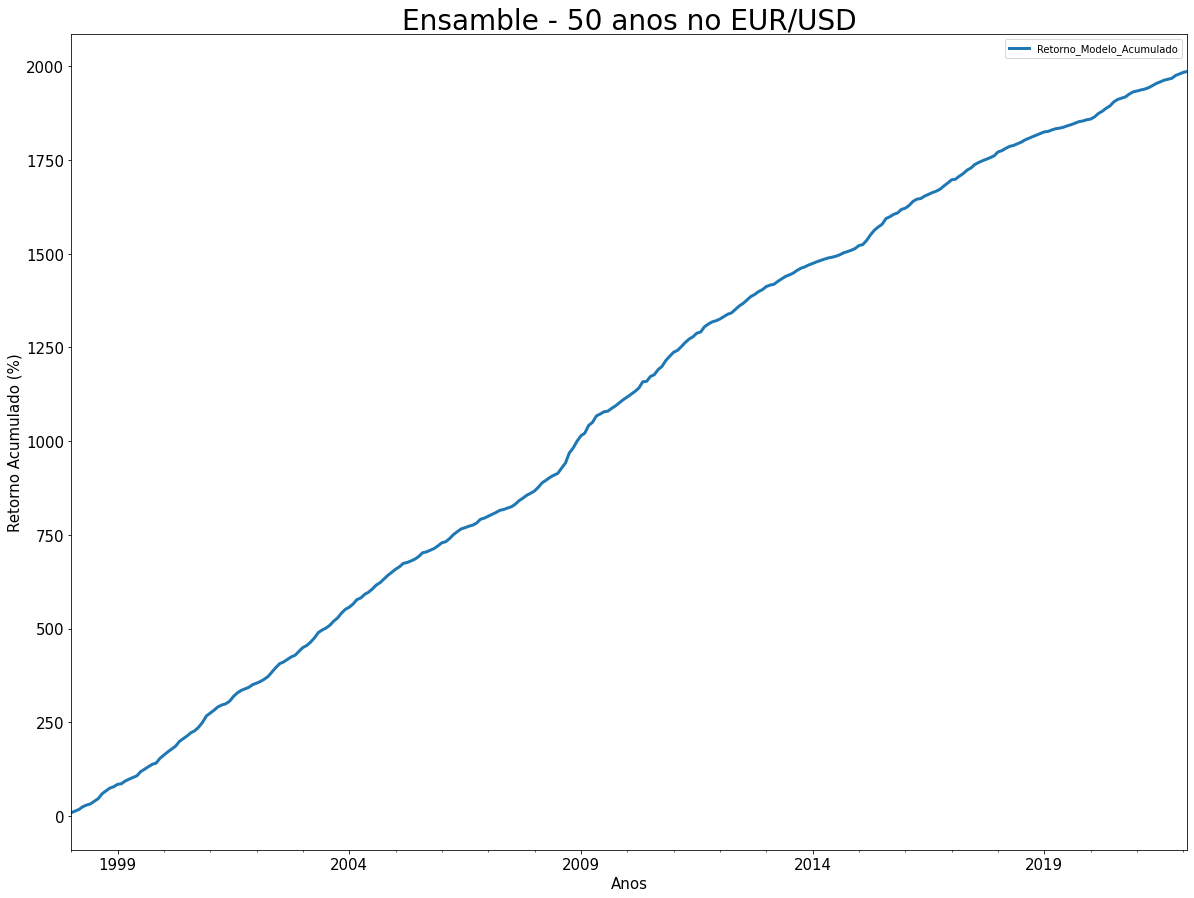

In [29]:
teste_agregado["Retorno_Modelo_Acumulado"].plot(figsize=(20,15)
                                     , linewidth = 3
                                     , fontsize = 15)
plt.xlabel("Anos"
           , fontsize = 15);
plt.ylabel("Retorno Acumulado (%)"
           , fontsize = 15);
plt.title("Ensamble - 50 anos no EUR/USD", fontsize = 28)
plt.legend()
plt.show()

In [30]:
# Tipo de tabela dinamica
summary = df1_filtrado.copy()
summary["data"] = pd.to_datetime(summary["data"], format = "%Y-%m")

summary = summary.groupby([summary["data"].dt.year]).agg({"Retorno_Modelo": sum}) # agg = agregando

summary.index = summary.index.set_names(["Ano"])

summary*100

,Retorno_Modelo
Ano,
1972,1.044303
1973,79.464106
1974,39.509672
1975,33.990013
1976,20.468955
1977,22.731646
1978,18.581912
1979,7.503975
1980,35.051151


In [31]:
summary_mes = df1_filtrado.copy()
summary_mes["data"] = pd.to_datetime(summary_mes["data"], format = "%Y-%m")

summary_mes = summary_mes.groupby([summary_mes["data"].dt.year, summary_mes["data"].dt.month]).agg({"Retorno_Modelo": sum})

summary_mes.index = summary_mes.index.set_names(["Ano", "Mes"])

summary_mes*100

Retorno_Modelo
Ano  Mes                
1972 7         -0.191063
     8          0.456307
     9          0.978862
     10        -0.036117
     11        -0.033245
...                  ...
2021 10        -0.896565
     11         3.895592
     12         0.950990
2022 1         -2.299221
     2         -5.975913

[596 rows x 1 columns]

In [32]:
print("--- Joveminino: Resultado Ensemble EURUSD de 1972 à 2022 ---")
print("")
print("Treinamento: 1972-1997")
print("Teste      : 1998-2022")
#print("Sem uso de stop - custos operacionais não incluídos")
print("---------------------------------------------------")
print("")
print("Pior retorno mensal:     {} %".format(round(summary_mes["Retorno_Modelo"].min(), 3)*100))
print("Melhor retorno mensal:   {} %".format(round(summary_mes["Retorno_Modelo"].max(), 3)*100))
print("Média ganho mensal:      {} %".format(round(summary_mes["Retorno_Modelo"].mean(), 2)*100))
print("---------------------------------")
print("Pior retorno anual:      {} %".format(round(summary["Retorno_Modelo"].min(), 3)*100))
print("Melhor retorno anual:    {} %".format(round(summary["Retorno_Modelo"].max(), 3)*100))
print("Média ganho anual:       {} %".format(round(summary["Retorno_Modelo"].mean(), 2)*100))
print("---------------------------------")
print("# Anos negativos:        {}".format((summary["Retorno_Modelo"] < 0).sum()))
print("# Anos positivos:        {}".format((summary["Retorno_Modelo"] > 0).sum()))
print("---------------------------------")
print("# Meses negativos:       {}".format((summary_mes["Retorno_Modelo"] < 0).sum()))
print("# Meses positivos:       {}".format((summary_mes["Retorno_Modelo"] > 0).sum()))
print("---------------------------------")
print("# Total(simples):        {} %".format(round(summary_mes["Retorno_Modelo"].sum(), 3)*100))

--- Joveminino: Resultado Ensemble EURUSD de 1972 à 2022 ---

Treinamento: 1972-1997
Teste      : 1998-2022
---------------------------------------------------

Pior retorno mensal:     -19.400000000000002 %
Melhor retorno mensal:   26.200000000000003 %
Média ganho mensal:      1.0 %
---------------------------------
Pior retorno anual:      -26.8 %
Melhor retorno anual:    79.5 %
Média ganho anual:       15.0 %
---------------------------------
# Anos negativos:        12
# Anos positivos:        39
---------------------------------
# Meses negativos:       253
# Meses positivos:       343
---------------------------------
# Total(simples):        742.4000000000001 %


______________________________________________________

### Passo 8 - Salvar e carregar o modelo

In [111]:
# Salva o modelo

modelo = "ensemble_EURUSDpronto.sav"
pickle.dump(e_multi, open(modelo, "wb"))

In [3]:
# Carrega o modelo
import pickle
meu_modelo = pickle.load(open("ensemble_EURUSDpronto.sav", "rb"))

In [56]:
meu_modelo

StackingClassifier(estimators=[('Emod1', LogisticRegression(random_state=42)),
                               ('Emod2',
                                DecisionTreeClassifier(max_depth=3,
                                                       random_state=42)),
                               ('Emod3',
                                DecisionTreeClassifier(max_depth=8,
                                                       random_state=42)),
                               ('Emod4',
                                DecisionTreeClassifier(max_depth=10,
                                                       random_state=42))],
                   final_estimator=DecisionTreeClassifier(max_depth=3,
                                                          max_leaf_nodes=15,
                                                          min_samples_leaf=15,
                                                          min_samples_split=20,
                                                          rando

In [4]:
import sqlite3
from sqlite3 import Error

In [5]:
def conexao(db):
    global conex
    try:
        conex = sqlite3.connect(db)
        print("Conexao realizada")
    except Error as e:
        print(e)

In [6]:
conexao("C:\\sqlite\\databases\\EURUSD1.db")

Conexao realizada


In [10]:
# Isto daqui é o que voce vai fazer no dia a dia

# Escreve o novo registro no banco de dados
ponteiro = conex.cursor()
ponteiro.execute("""INSERT INTO EURUSD1 (data, hora, open, high,low,close,volume )
                VALUES ("25/03/2022", "00:00", "1.09965", "1.10377", "1.09806", "1.09828","0")""")
conex.commit()

In [11]:
def cria_variaveis(df):
    df1 = df
    df1["data"] = pd.to_datetime(df1["data"]).dt.normalize()
    df1 = df1.set_index("data")
    # Lag de x periodos
    periodos = 2
    # Calculo do retorno

    df1["Retorno"] = df1["close"].pct_change(periodos)
    # Lag positivo de x periodos
    df1["Lag_P5"] = df1["close"].shift(periodos)
   # Atualização das Variaveis

    # Desvio Padrao de 5 dias
    df1["std5"] = df1["Retorno"].rolling(5).std()

    # Desvio Padrao de 10 dias
    df1["std10"] = df1["Retorno"].rolling(10).std()

    # Desvio Padrao de 15 dias
    df1["std15"] = df1["Retorno"].rolling(15).std()

    # Proporçao do corpo do candle em relacao ao range do dia
    df1["prop"] = (df1["close"]-df1["open"])/(df1["high"]-df1["low"])

    # Direçao do dia atual
    df1["dir_D"] = np.where(df1['close'] > df1['open'] , '1', '0')

    # Direçao D-1
    df1["dir_D-1"] = df1["dir_D"].shift(1)

    # Direçao D-2
    df1["dir_D-2"] = df1["dir_D"].shift(2)

    # Direçao D-3
    df1["dir_D-3"] = df1["dir_D"].shift(3)

    # Media Movel de 15 dias std5
    df1["mm_std5"] = df1["std5"].rolling(15).mean()

    # Media Movel de 15 dias std5
    df1["mm_std10"] = df1["std10"].rolling(15).mean()

    # Media Movel de 15 dias std5
    df1["mm_std15"] = df1["std15"].rolling(15).mean()

    # RSL std5
    df1["RSL_std5"] = (df1["std5"]/df1["std5"].rolling(15).mean())-1

    # RSL std10
    df1["RSL_std10"] = (df1["std10"]/df1["std10"].rolling(15).mean())-1

    # RSL std15
    df1["RSL_std15"] = (df1["std15"]/df1["std15"].rolling(15).mean())-1

    # Aplicando a fisica

    p = 2 

    # Velocidade de p dias
    df1["v"] = (df1["Retorno"] - df1["Retorno"].shift(p))/p

    # Aceleraçao de p dias
    df1["a"] = (df1["v"] - df1["v"].shift(p))/p

    # Força
    # Calculando a massa
    df1["m"] = df1["Retorno"].rolling(p).sum()
    df1["f"] = df1["m"]*df1["a"]

    # Energia cinética
    df1["T"] = 0.5*df1["m"]*df1["v"]*df1["v"]


    # Trabalho 
    # cateto_oposto
    cat_op = df1["Retorno"].rolling(p).sum()-df1["Retorno"].rolling(1).sum()
    cat_ad = p
    df1["cat"] = cat_op/cat_ad
    df1 = df1.dropna(axis = 0)
    df1["w"] = df1["f"]*np.cos(np.arctan(df1["cat"]))

    # Energia potencial
    df1["k"] = cat_op*df1["m"]

    # Torque
    df1["tau"] = df1["f"]*np.sin(np.arctan(df1["cat"]))

    # Momentum
    df1["M"] = df1["m"]*df1["v"]

    # Gravidade
    df1["g"] = df1["m"]*df1["Retorno"].rolling(p).sum()/(df1["m"]/df1["Retorno"].rolling(p).sum())*(df1["m"]/df1["Retorno"].rolling(p).sum())
    # Filtrando os valores missing
    df1_filtrado = df1.dropna(axis = 0) 
    df1_filtrado= df1_filtrado.drop(["std5","std10","std15","mm_std5","mm_std10","mm_std15"], axis = 1)
    corte = 5

    df1_filtrado["RSL_std5"] = pd.qcut(df1_filtrado["RSL_std5"], corte, labels = False)
    df1_filtrado["RSL_std10"] = pd.qcut(df1_filtrado["RSL_std10"], corte, labels = False)
    df1_filtrado["RSL_std15"] = pd.qcut(df1_filtrado["RSL_std15"], corte, labels = False)
    df1_filtrado["v"] = pd.qcut(df1_filtrado["v"], corte, labels = False)
    df1_filtrado["a"] = pd.qcut(df1_filtrado["a"], corte, labels = False)
    df1_filtrado["m"] = pd.qcut(df1_filtrado["m"], corte, labels = False)
    df1_filtrado["f"] = pd.qcut(df1_filtrado["f"], corte, labels = False)
    df1_filtrado["T"] = pd.qcut(df1_filtrado["T"], corte, labels = False)
    df1_filtrado["w"] = pd.qcut(df1_filtrado["w"], corte, labels = False)
    df1_filtrado["k"] = pd.qcut(df1_filtrado["k"], corte, labels = False)
    df1_filtrado["tau"] = pd.qcut(df1_filtrado["tau"], corte, labels = False)
    df1_filtrado["M"] = pd.qcut(df1_filtrado["M"], corte, labels = False)
    df1_filtrado["g"] = pd.qcut(df1_filtrado["g"], corte, labels = False)
    
    # Criando variàveis com os resultados do pd.qcut
    # Criando um sistema que vai interpretar o valor que vai ser dado pela variavel euqe se pode atingir o mesmo valor do pd.qcut

    #Exemplo
    RSL_std5_cut = np.where(df1_filtrado["RSL_std5"] <= -0.395, 0
                        , np.where(((df1_filtrado["RSL_std5"] > -0.395) & (df1_filtrado["RSL_std5"] <= -0.185)), 1
                                  , np.where(((df1_filtrado["RSL_std5"] > -0.185) & (df1_filtrado["RSL_std5"] <= 0.0475)), 2
                                            , np.where(((df1_filtrado["RSL_std5"] > 0.0475) & (df1_filtrado["RSL_std5"] <= 0.387)), 3
                                                      , 4)
                                            )
                                  )
                       )

    RSL_std10_cut = np.where(df1_filtrado["RSL_std10"] <= -0.329, 0
                        , np.where(((df1_filtrado["RSL_std10"] > -0.329) & (df1_filtrado["RSL_std10"] <= -0.134)), 1
                                  , np.where(((df1_filtrado["RSL_std10"] > -0.134) & (df1_filtrado["RSL_std10"] <= 0.0669)), 2
                                            , np.where(((df1_filtrado["RSL_std10"] > 0.0669) & (df1_filtrado["RSL_std10"] <= 0.343)), 3
                                                      , 4)
                                            )
                                  )
                       )

    RSL_std15_cut = np.where(df1_filtrado["RSL_std15"] <= -0.289, 0
                        , np.where(((df1_filtrado["RSL_std15"] > -0.289) & (df1_filtrado["RSL_std15"] <= -0.105)), 1
                                  , np.where(((df1_filtrado["RSL_std15"] > -0.105) & (df1_filtrado["RSL_std15"] <= 0.07)), 2
                                            , np.where(((df1_filtrado["RSL_std15"] > 0.07) & (df1_filtrado["RSL_std15"] <= 0.316)), 3
                                                      , 4)
                                            )
                                  )
                       )
                    
    v_cut = np.where(df1_filtrado["v"] <= -0.00465, 0
                        , np.where(((df1_filtrado["v"] > -0.465) & (df1_filtrado["v"] <= -0.00132)), 1
                                  , np.where(((df1_filtrado["v"] > -0.132) & (df1_filtrado["v"] <= 0.0014)), 2
                                            , np.where(((df1_filtrado["v"] > 0.0014) & (df1_filtrado["v"] <= 0.00456)), 3
                                                      , 4)
                                            )
                                  )
                       )

    a_cut = np.where(df1_filtrado["a"] <= -0.00398, 0
                        , np.where(((df1_filtrado["a"] > -0.00398) & (df1_filtrado["a"] <= -0.00109)), 1
                                  , np.where(((df1_filtrado["a"] > -0.00109) & (df1_filtrado["a"] <= 0.00116)), 2
                                            , np.where(((df1_filtrado["a"] > 0.00116) & (df1_filtrado["a"] <= 0.00402)), 3
                                                      , 4)
                                            )
                                  )
                       )
    
    m_cut = np.where(df1_filtrado["m"] <= -0.0108, 0
                        , np.where(((df1_filtrado["m"] > -0.0108) & (df1_filtrado["m"] <= -0.0029)), 1
                                  , np.where(((df1_filtrado["m"] > -0.0029) & (df1_filtrado["m"] <= 0.0032)), 2
                                            , np.where(((df1_filtrado["m"] > 0.0032) & (df1_filtrado["m"] <= 0.00402)), 3
                                                      , 4)
                                            )
                                  )
                       )

    f_cut = np.where(df1_filtrado["m"] <= -2.62, 0
                        , np.where(((df1_filtrado["f"] > -2.62) & (df1_filtrado["f"] <= -2.19)), 1
                                  , np.where(((df1_filtrado["f"] > -2.62) & (df1_filtrado["f"] <= 7.86)), 2
                                            , np.where(((df1_filtrado["f"] > 7.86) & (df1_filtrado["f"] <= 3.96)), 3
                                                      , 4)
                                            )
                                  )
                       ) 

    w_cut = np.where(df1_filtrado["w"] <= -2.62, 0
                        , np.where(((df1_filtrado["w"] > -2.62) & (df1_filtrado["w"] <= -2.19)), 1
                                  , np.where(((df1_filtrado["w"] > -2.19) & (df1_filtrado["w"] <= 7.86)), 2
                                            , np.where(((df1_filtrado["w"] > 7.86) & (df1_filtrado["w"] <= 3.96)), 3
                                                      , 4)
                                            )
                                  )
                       )       

    k_cut = np.where(df1_filtrado["k"] <= 8.46, 0
                        , np.where(((df1_filtrado["k"] > 8.46) & (df1_filtrado["k"] <= 1.67)), 1
                                  , np.where(((df1_filtrado["k"] > 1.67) & (df1_filtrado["k"] <= 5.89)), 2
                                            , np.where(((df1_filtrado["k"] > 5.89) & (df1_filtrado["k"] <= 0.000169)), 3
                                                      , 4)
                                            )
                                  )
                       ) 

    tau_cut = np.where(df1_filtrado["tau"] <= -8.41, 0
                        , np.where(((df1_filtrado["tau"] > -8.41) & (df1_filtrado["tau"] <= -4.16)), 1
                                  , np.where(((df1_filtrado["tau"] > -4.16) & (df1_filtrado["tau"] <= 5.34)), 2
                                            , np.where(((df1_filtrado["tau"] > 5.34) & (df1_filtrado["tau"] <= 8.48)), 3
                                                      , 4)
                                            )
                                  )
                       )        

    M_cut = np.where(df1_filtrado["M"] <= -1.26, 0
                        , np.where(((df1_filtrado["M"] > -1.26) & (df1_filtrado["M"] <= 1.34)), 1
                                  , np.where(((df1_filtrado["M"] > 1.34) & (df1_filtrado["M"] <= 1.93)), 2
                                            , np.where(((df1_filtrado["M"] > 1.93) & (df1_filtrado["M"] <= 7.04)), 3
                                                      , 4)
                                            )
                                  )
                       )   

    g_cut = np.where(df1_filtrado["g"] <= 8.86, 0
                        , np.where(((df1_filtrado["g"] > 8.86) & (df1_filtrado["g"] <= 4.26)), 1
                                  , np.where(((df1_filtrado["g"] > 4.26) & (df1_filtrado["g"] <= 0.000121)), 2
                                            , np.where(((df1_filtrado["g"] > 0.000121) & (df1_filtrado["g"] <= 0.000333)), 3
                                                      , 4)
                                            )
                                  )
                       ) 

    
    # Para o zig zag dos retornos
    df1["Retorno1"] = df1["Retorno"].shift(1)
    df1["Retorno2"] = df1["Retorno"].shift(2)

    df1["Zigzag_alta"] = np.where(((df1["Retorno"] > 0) & (df1["Retorno1"] < 0) & (df1["Retorno2"] > 0)), 1, 0)
    df1["Zigzag_baixa"] = np.where(((df1["Retorno"] < 0) & (df1["Retorno1"] > 0) & (df1["Retorno2"] < 0)), -1, 0)
    df1["Zigzag"] = df1["Zigzag_alta"] + df1["Zigzag_baixa"]

    # Resistencia - R=V/I onde V é a amplitude maxima dos ultimos retornos
    # Novo periodo
    p = 2

    df1["V_Max"] = df1["Retorno"].rolling(p).max()
    df1["V_Min"] = df1["Retorno"].rolling(p).min()
    df1["I"] = df1["Retorno"].rolling(p).sum()

    # Variaveis de Indicadores técnicos - Biblioteca TA

    # Inicializa o indicador
    indicator_atr14 = ta.volatility.AverageTrueRange(high = df1["high"], low = df1["low"]
                                                  , close = df1["close"], window = 14)

    indicator_bb = ta.volatility.bollinger_wband(close = df1["close"], window = 20, window_dev = 2)
    indicator_rsi14 = ta.momentum.RSIIndicator(close = df1["close"], window = 14)
    indicator_rsi2 = ta.momentum.RSIIndicator(close = df1["close"], window = 2)
    indicator_stoc = ta.momentum.StochasticOscillator(high= df1["high"], low = df1["low"]
                                                  , close = df1["close"], window = 14, smooth_window = 3)

    # Variavel abertura das bandas
    df1["abertura_bb"] = indicator_bb

    df1["RSI14"] = indicator_rsi14.rsi()
    df1["RSI2"] = indicator_rsi2.rsi()
    df1["STOC"] = indicator_stoc.stoch()
    df1["ATR14"] = indicator_atr14.average_true_range()

    # Filtrando os valores missing

    df1_filtrado = df1.dropna(axis = 0) 

    df1_filtrado = df1_filtrado.drop(["mm_std5", "mm_std10", "mm_std15", "Retorno1"
                                  , "Retorno2", "Zigzag_alta", "Zigzag_baixa"
                                 ], axis = 1)
                       
    return(df1_filtrado)

In [12]:
# Recupera a tabela do SQLite

base = cria_variaveis(
    pd.read_sql(
        "select data, open, high, low, close from EURUSD1"
        , conex)
)

In [10]:
base.columns

Index(['open', 'high', 'low', 'close', 'Retorno', 'Lag_P5', 'std5', 'std10',
       'std15', 'prop', 'dir_D', 'dir_D-1', 'dir_D-2', 'dir_D-3', 'RSL_std5',
       'RSL_std10', 'RSL_std15', 'v', 'a', 'm', 'f', 'T', 'cat', 'w', 'k',
       'tau', 'M', 'g', 'Zigzag', 'V_Max', 'V_Min', 'I', 'abertura_bb',
       'RSI14', 'RSI2', 'STOC', 'ATR14'],
      dtype='object')

In [13]:
# Funçao para a prediçao

def predicao (tab):
    aux = meu_modelo.predict(tab.iloc[:, 6:base.shape[1]])
    aux = np.where(aux == -1, 1, 0)
    mensagem = np.where(aux[-1] == 1, "Compra", "Vende")
    return (print("Previsao para amanha: " + str(mensagem)))

In [14]:
predicao(base)

Previsao para amanha: Vende


In [15]:
conex.close()